In [28]:
import os, shutil
import pandas as pd
import numpy as np

import kwant

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [29]:

mpl.rcParams['text.usetex'] = True
# matplotlib.rcParams['figure.figsize'] = ((3+3/8), 0.5*(3+3/8))
plt.rc('text.latex', preamble=r'\usepackage{bm,braket}')
mpl.rcParams['figure.dpi'] = 300

In [30]:
# useful definitions for later
sigma_0 = np.array([[1, 0], [0, 1]])
sigma_x = np.array([[0, 1], [1, 0]])
sigma_y = np.array([[0, -1j], [1j, 0]])
sigma_z = np.array([[1, 0], [0, -1]])
sigmas = [sigma_0, sigma_x, sigma_y, sigma_z]

In [31]:
# tilt profile
def tilt(pos, **kwargs):
    pos0 = -np.asarray(kwargs.get('pos0', [0,0]))
    # length scale of the tilt
    r0 = kwargs.get('r0', 5)
    
    if r0 == 0:
        return np.asarray([0,0])
    # exponent of the power-law
    alpha = -kwargs.get('alpha', 1.0)
    
    rvec = pos - pos0
    rabs = np.linalg.norm(rvec)
    return (r0/rabs)**alpha * rvec/rabs

In [32]:
# true if rvec is inside a Lx * Ly rectangle centered at (0,0)
def is_in_rectangle(pos, **kwargs):
        Ls = (kwargs.get('Ls', (10,5)))
        rvec = pos - np.asarray(kwargs.get('pos0', [0,0]))
        return all([-r < p < r for (p, r) in zip(rvec, Ls)])

In [33]:
def make_system(sigmas, **kwargs):
    # default lattice: simple cubic
    primitive_vectors = kwargs.get('primitive_vectors', [[1,0], [0,1]])
    # region function to populate lattice, default : no region
    def is_in_region(pos, start=[0,0]):
        return is_in_rectangle(pos, **kwargs)
    # starting position to fill the lattice
    pos0 = kwargs.get('pos0', [0,0])
    # mass gap for the superficial Weyl nodes at the boundary BZ
    k0 = kwargs.get('k0', 1)
    # if sites are passed, hoppings are only set on the sites
    sites = kwargs.get('sites', [])

    # default tilt : vanishing everywhere
    tilt_function = lambda pos : tilt(pos, **kwargs)
    
    # create the lattice
    lat = kwant.lattice.Monatomic(primitive_vectors, norbs=2)

    # sym specifies the semi-infinite direction of a lead
    sym = kwargs.get('sym', [])
    if sym != []:
        sym_lead = kwant.TranslationalSymmetry(sym)
        syst = kwant.Builder(sym_lead)
    else:
        syst = kwant.Builder()

    # on-site hopping elements
    if sites == []:
        syst[lat.shape(is_in_region, pos0)] = -2/k0*sigmas[3]
    else:
        for s in sites:
            syst[lat(*s.pos)] = -2/k0*sigmas[3]
            if sym != []:
                syst[lat(*(s.pos+sym))] = -2/k0*sigmas[3]

    # nearest neighbor terms
    nnx = 0.5/k0*sigmas[3] - 0.5j*1*sigmas[1]
    nny = 0.5/k0*sigmas[3] - 0.5j*1*sigmas[2]
    # space-dependent tilt, taken in the center between sites
    def fx(site1, site2):
        s1p, s2p = site1.pos, site2.pos
        (x,y) = 0.5*(s1p+s2p)
        return nnx - 0.5j*sigmas[0]*tilt_function((x,y))[0]
    def fy(site1, site2):
        s1p, s2p = site1.pos, site2.pos
        (x,y) = 0.5*(s1p+s2p)
        return nny - 0.5j*sigmas[0]*tilt_function((x,y))[1]
    syst[kwant.builder.HoppingKind((1, 0), lat, lat)] = fx
    syst[kwant.builder.HoppingKind((0, 1), lat, lat)] = fy
    return syst

In [39]:
syst = kwant.Builder()
params = {'Ls': (100, 50), 'k0': 1, 'energy': 0.8, 'r0': 0, 'alpha': 1}
syst = make_system(sigmas, **params)
# kwant.plot(syst);

In [40]:
fsyst = syst.finalized()  # temporary finalized system, will be overwritten later
sites = fsyst.sites  # get all sites
positions = np.asarray([s.pos for s in sites])
xmin, xmax = np.min(positions[:,0]), np.max(positions[:,0])
ymin, ymax = np.min(positions[:,1]), np.max(positions[:,1])

# select all edge sites of the system
xmin_sites = np.where(positions[:,0] == xmin)[0]
xmax_sites = np.where(positions[:,0] == xmax)[0]
ymin_sites = np.where(positions[:,1] == ymin)[0]
ymax_sites = np.where(positions[:,1] == ymax)[0]
bottom_sites_1 = np.where(positions[:,1] < int(ymin*0.5))[0]
bottom_sites_2 = np.where(positions[:,1] < int(ymin*0.9))[0]
bottom_sites_intersection = np.intersect1d(bottom_sites_1, bottom_sites_2)
bottom_sites_difference = np.setdiff1d(bottom_sites_1, bottom_sites_2)

lead_sites = []
lead_sites.append(np.intersect1d(xmin_sites, bottom_sites_difference))
lead_sites.append(np.intersect1d(xmin_sites, bottom_sites_intersection))
lead_sites.append(np.setdiff1d(np.setdiff1d(xmin_sites, lead_sites[0]), lead_sites[1]))
lead_sites.append(xmax_sites)
lead_sites.append(ymin_sites)
lead_sites.append(ymax_sites)

# this order is determined by the order of lead_sites
lead_syms = [(-1, 0),(-1, 0),(-1, 0),(+1, 0),(0, -1),(0, +1)]
lead_centers = [(np.mean(positions[ls,0]), np.mean(positions[ls,1])) for ls in lead_sites]

# # visualize it, to verify
# fig, ax = plt.subplots(1,1)
# ax.scatter(positions[:,0], positions[:,1])
# for ls in lead_sites:
#     ax.scatter(positions[ls,0], positions[ls,1])
# for (lc,ls) in zip(lead_centers,lead_syms):
#     ax.scatter(lc[0], lc[1], marker='x', color='black')
#     ax.quiver(lc[0], lc[1], ls[0], ls[1])
# plt.tight_layout()
# ax.set_xlim(1.15*np.asarray((xmin,xmax)))
# ax.set_ylim(1.3*np.asarray((ymin,ymax)));


---------------------------------------------------------------------------------------------------- 
system finalized.
---------------------------------------------------------------------------------------------------- 
compute scattering states
5


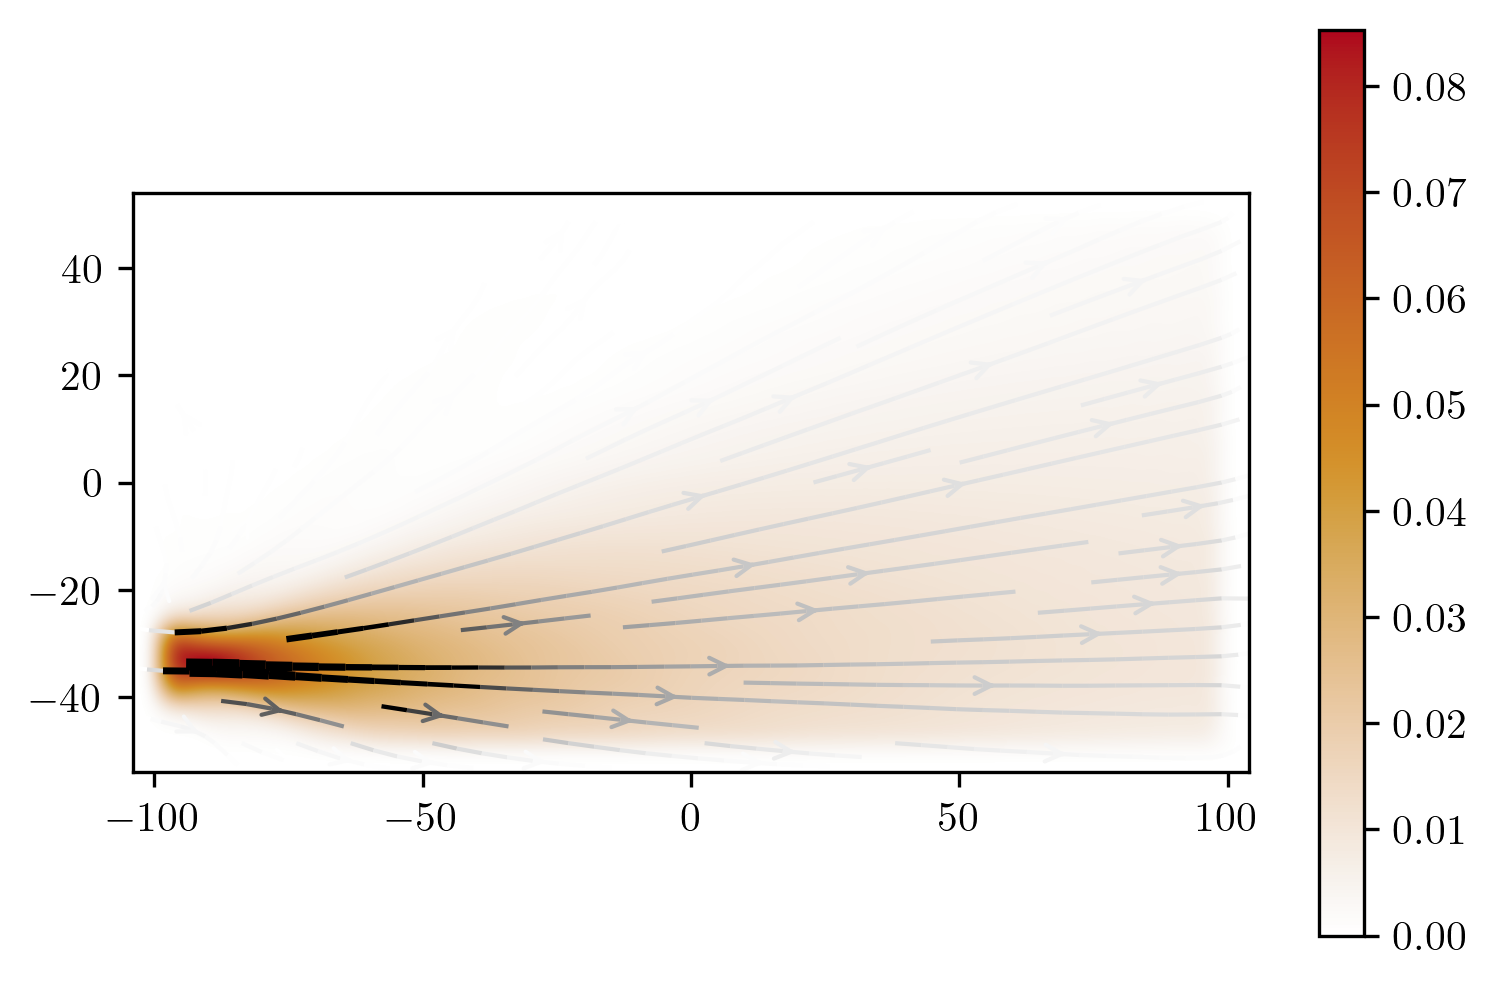

---------------------------------------------------------------------------------------------------- 
computation finished.


In [41]:

for (id, (ls,lc,s)) in enumerate(zip(lead_syms, lead_centers, lead_sites)):
    tp = [sites[id] for id in s]
    lead = make_system(sigmas, sym=ls, pos0=lc, sites=tp, r0=0)
    syst.attach_lead(lead)
    # kwant.plotter.bands(lead.finalized())
fsyst = syst.finalized()
print('-'*100, '\nsystem finalized.')
# kwant.plot(fsyst);
sites = fsyst.sites
positions = np.asarray([s.pos for s in sites])

# df = pd.DataFrame()
# X, Y, Z = [], [], []
# for p in positions:
#     X.append(p[0]), Y.append(p[1]), Z.append(np.linalg.norm(tilt(p,pos0=[0.1,0],**params)))
# df['X'], df['Y'], df['Z'] = X, Y, Z
# pivotted = df.pivot('X', 'Y', 'Z')
# plt.imshow(pivotted)
# get the scattering states
print('-'*100, '\ncompute scattering states')
# propagating_modes, _ = fsyst.leads[0].modes(energy=energy)
scattering_states = kwant.wave_function(fsyst, energy=params['energy'])
ss = [scattering_states(i) for i in range(len(fsyst.leads))]
J_0 = kwant.operator.Current(fsyst).bind()
print(len(ss[0]))
psi = ss[0][0]
kwant.plotter.current(fsyst, J_0(psi))
print('-'*100, '\ncomputation finished.')